# 16.3.1 시뮬레이션 클래스

In [1]:
import numpy as np
from sn_random_numbers import *
from simulation_class import *

In [2]:
class geometric_brownian_motion(simulation_class):
    ''' 블랙-숄즈-머튼의 기하 브라운 운동 모형에 따른 시뮬레이션 경로를 생성하는 클래스
    
    속성
    ====
    name : string
        객체 이름
    mar_env : instance of market_environment
        시뮬레이션에 필요한 시장 환경 데이터
    corr : Boolean
        다른 시뮬레이션 객체와 상관관계가 있으면 True
        
    Method
    ======
    update :
        파라미터 갱신
    generate_paths :
        시장 환경이 주어지면 몬테카를로 경로를 반환
    '''
    
    def __init__(self, name, mar_env, corr = False):
        super(geometric_brownian_motion, self).__init__(name, mar_env, corr)
        
    def update(self, initial_value = None, volatility = None, final_date = None):
        if initial_value is not None:
            self.initial_value = initial_value
            
        if volatility is not None:
            self.volatility = volatility
            
        if final_date is not None:
            self.final_date = final_date 
        
        self.instrument_values = None
    
    def generate_paths(self, fixed_seed = False, day_count = 365.):
        if self.time_grid is None:
            self.generate_time_grid()
                # 일반적 시뮬레이션 클래스의 Method
        
        # time_grid의 날짜 수
        M = len(self.time_grid)
        
        # 경로 수
        I = self.paths
        
        # 경로 시뮬레이션을 위한 배열 초기화
        paths = np.zeros((M, I))
        
        # initial_value로 처음 날짜 초기화
        paths[0] = self.initial_value
        
        if not self.correlated:
            # 상관관계 없을 시 난수 생성
            rand = sn_random_numbers((1, M, I), fixed_seed = fixed_seed)
        
        else:
            # 상관관계 있을 시 시장 환경에서 제공하는 random_numbers 사용
            rand = self.random_numbers
        
        short_rate = self.discount_curve.short_rate
            # 증가율을 위한 단기 이자율
        
        for t in range(1, len(self.time_grid)):
            if not self.correlated:
                ran = rand[t]
            
            else:
                ran = np.dot(self.cholesky_matrix, rand[:, t, :])
                ran = ran[self.rn_set]
            
            dt = (self.time_grid[t] - self.time_grid[t-1]).days / day_count
                # 두 날짜 차이를 1년 기준 비율로 표현
            
            paths[t] = paths[t-1] * np.exp((short_rate - 0.5 * self.volatility ** 2) * dt + self.volatility * np.sqrt(dt) * ran)
        
        self.instrument_values = paths

# 16.3.2 사용 예시
 - 1. Market_environment 객체 생성 * 주의 : 넣는 순서 중요!
 - 2. 모형 시뮬레이션 객체 생성

In [3]:
from dx_frame import *

In [4]:
# 1
me_gbm = market_environment('me_gbm', dt.datetime(2015, 1, 1))
me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2015, 12, 31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
me_gbm.add_constant('paths', 10000)

In [5]:
# 1
csr = constant_short_rate('csr', 0.05)

In [6]:
# 1
me_gbm.add_curve('discount_curve', csr)

In [7]:
# 2
#from dx_simulation import *
gbm = geometric_brownian_motion('gbm', me_gbm)

In [8]:
gbm.generate_time_grid()

In [9]:
gbm.time_grid

array([datetime.datetime(2015, 1, 1, 0, 0),
       datetime.datetime(2015, 1, 31, 0, 0),
       datetime.datetime(2015, 2, 28, 0, 0),
       datetime.datetime(2015, 3, 31, 0, 0),
       datetime.datetime(2015, 4, 30, 0, 0),
       datetime.datetime(2015, 5, 31, 0, 0),
       datetime.datetime(2015, 6, 30, 0, 0),
       datetime.datetime(2015, 7, 31, 0, 0),
       datetime.datetime(2015, 8, 31, 0, 0),
       datetime.datetime(2015, 9, 30, 0, 0),
       datetime.datetime(2015, 10, 31, 0, 0),
       datetime.datetime(2015, 11, 30, 0, 0),
       datetime.datetime(2015, 12, 31, 0, 0)], dtype=object)

In [10]:
# 3
%time paths_1 = gbm.get_instrument_values()

Wall time: 8.02 ms


In [11]:
gbm.update(volatility = 0.5)

In [12]:
%time paths_2 = gbm.get_instrument_values()

Wall time: 8.98 ms


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([16436., 16495., 16556., 16617., 16679., 16740., 16801.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

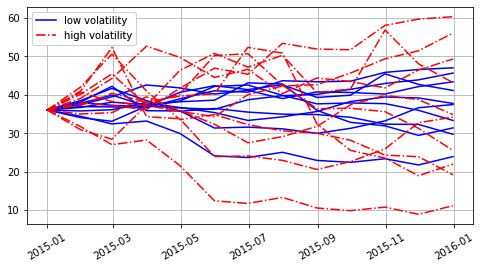

In [14]:
plt.figure(figsize = (8, 4))
p1 = plt.plot(gbm.time_grid, paths_1[:, :10], 'b')
p2 = plt.plot(gbm.time_grid, paths_2[:, :10], 'r-.')
plt.grid(True)
l1 = plt.legend([p1[0], p2[0]], ['low volatility', 'high volatility'], loc = 2)
plt.gca().add_artist(l1)
plt.xticks(rotation = 30)